In [37]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical plots
from sklearn.model_selection import train_test_split  # Split the dataset into training and test sets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score  # Print precision, recall, and f1-score
from sklearn.linear_model import LogisticRegression  # Train the classification model
from sklearn.decomposition import PCA
import torch  # PyTorch for deep learning (if needed)
import torch.nn as nn  # PyTorch for deep learning (if needed)
import torch.optim as optim  # PyTorch for deep learning (if needed)
import seaborn as sns  # For statistical plots
import matplotlib.pyplot as plt  # For data visualization
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

In [38]:
df = pd.read_csv("IRIS.csv")  # Load the dataset from CSV

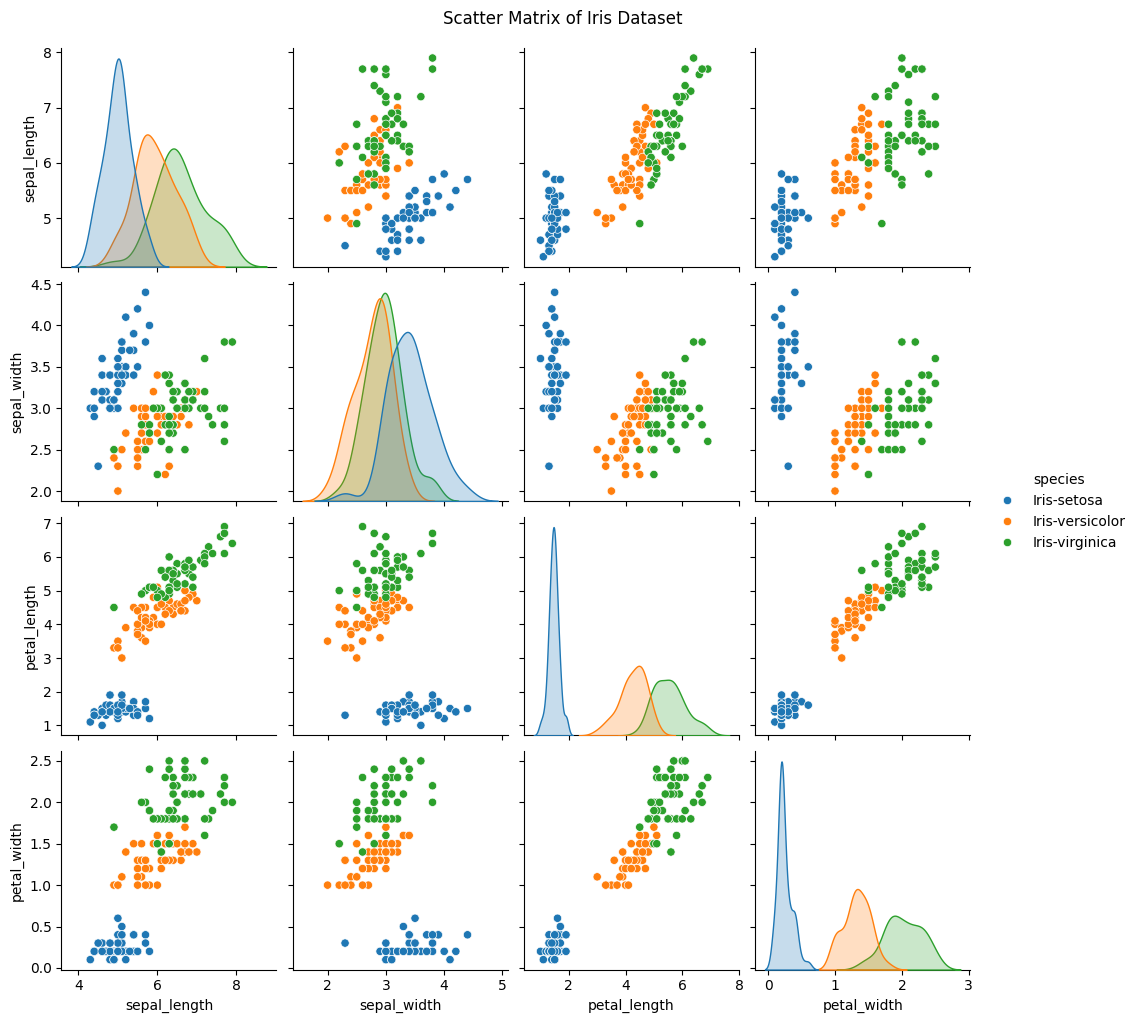

In [39]:
plotScatterMatrix(df, 12, 10)

In [40]:
# One-way ANOVA
anova_result = stats.f_oneway(
    df[df.species == "Iris-setosa"].petal_width,
    df[df.species == "Iris-versicolor"].petal_width,
    df[df.species == "Iris-virginica"].petal_width,
)
print("ANOVA p-value:", anova_result.pvalue)

ANOVA p-value: 4.376956957488959e-85


In [41]:
# Post-hoc: Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['petal_width'], groups=df['species'], alpha=0.05)
print(tukey)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1          group2     meandiff p-adj lower  upper  reject
-------------------------------------------------------------------
    Iris-setosa Iris-versicolor    1.082   0.0 0.9849 1.1791   True
    Iris-setosa  Iris-virginica    1.782   0.0 1.6849 1.8791   True
Iris-versicolor  Iris-virginica      0.7   0.0 0.6029 0.7971   True
-------------------------------------------------------------------


In [42]:
# Pairwise t-tests
from itertools import combinations

groups = df['species'].unique()
pairs = list(combinations(groups, 2))
pvals = []

for g1, g2 in pairs:
    t_stat, p_val = stats.ttest_ind(
        df[df.species == g1].petal_width,
        df[df.species == g2].petal_width,
    )
    pvals.append(p_val)

# Correct for multiple comparisons
reject, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')
pairwise_results = pd.DataFrame({
    'Comparison': [f"{a} vs {b}" for a, b in pairs],
    'Corrected p-value': pvals_corrected,
    'Significant': reject
})
print(pairwise_results)

                          Comparison  Corrected p-value  Significant
0     Iris-setosa vs Iris-versicolor       1.376724e-55         True
1      Iris-setosa vs Iris-virginica       1.074816e-64         True
2  Iris-versicolor vs Iris-virginica       6.691227e-26         True


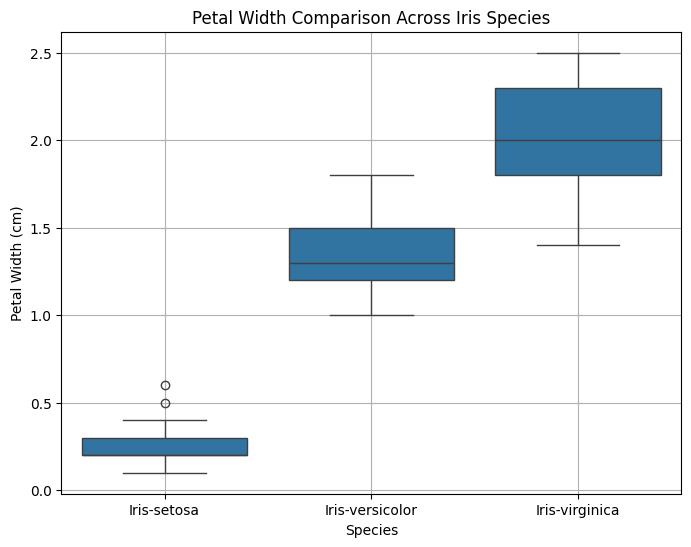

In [43]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x="species", y="petal_width", data=df)
plt.title("Petal Width Comparison Across Iris Species")
plt.xlabel("Species")
plt.ylabel("Petal Width (cm)")
plt.grid(True)
plt.show()

In [44]:
X = df.drop("species", axis=1).values
y = df["species"].values

In [45]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Fit and scale the training data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)  # Split the dataset into training and test sets

In [47]:
scaler = StandardScaler()  # Initialize the scaler
X_train_scaled = scaler.fit_transform(X_train)  # Fit and scale the training data
X_test_scaled = scaler.transform(X_test)  # Scale the test data using the same scaler

In [48]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [49]:
#Arsitektur MLP dengan PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

mlp_model = MLP()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

In [51]:
# Pelatihan Model
train_losses = []
train_accuracies = []

for epoch in range(100):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Simpan loss dan akurasi
    train_losses.append(loss.item())
    _, predicted = torch.max(outputs, 1)  # Predict species for the test set
    accuracy = (predicted == y_train_tensor).float().mean().item()  # Predict species for the test set
    train_accuracies.append(accuracy)

In [52]:
# Evaluasi MLP
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp_tensor = mlp_model(X_test_tensor)
    y_pred_mlp = torch.argmax(y_pred_mlp_tensor, axis=1).numpy()

print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))  # Print precision, recall, and f1-score

MLP Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [53]:
# Logistic Regression Model
logreg_model = LogisticRegression(max_iter=200)  # Train the classification model
logreg_model.fit(X_train_scaled, y_train)  # Train the classification model
y_pred_logreg = logreg_model.predict(X_test_scaled)  # Predict species for the test set

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=le.classes_))  # Print precision, recall, and f1-score

Logistic Regression Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



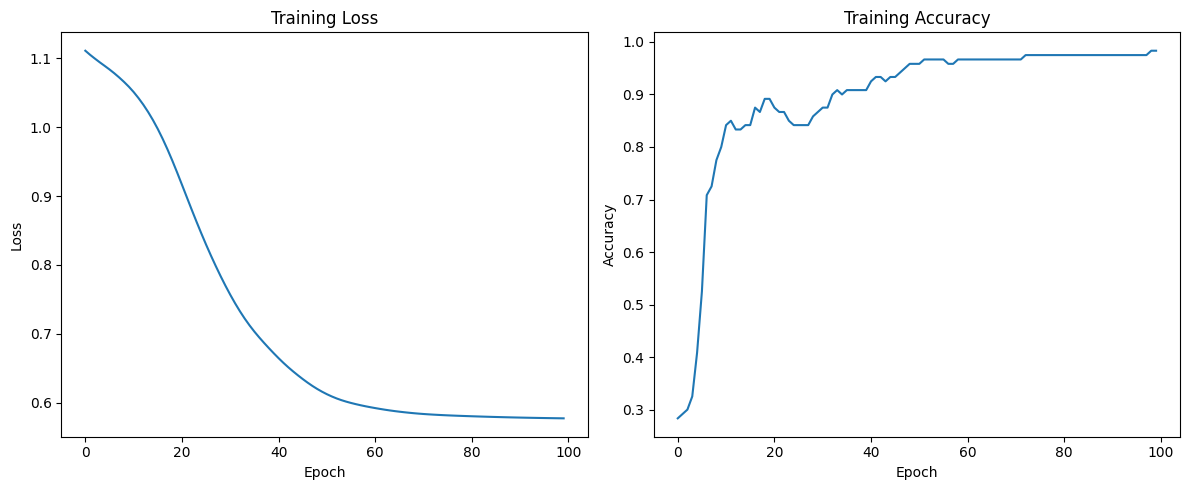

In [54]:
# Visualisasi Loss dan Akurasi Selama Training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

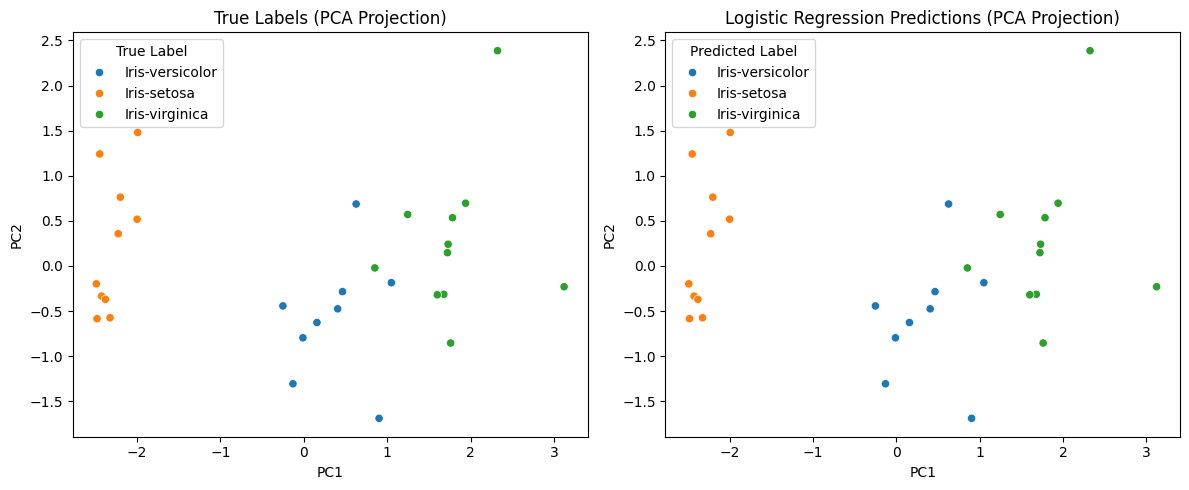

In [55]:
# Visualisasi Logistic Regression dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)  # Fit and scale the training data


df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'True Label': le.inverse_transform(y_test),  # Scale the test data using the same scaler
    'Predicted Label': le.inverse_transform(y_pred_logreg)  # Scale the test data using the same scaler
})


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='True Label', ax=axes[0])
axes[0].set_title("True Labels (PCA Projection)")
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Predicted Label', ax=axes[1])
axes[1].set_title("Logistic Regression Predictions (PCA Projection)")
plt.tight_layout()
plt.show()

In [56]:
# Inference Function (Prediksi Data Baru)
def predict_new(sample):  # Predict species for the test set
    sample_scaled = scaler.transform([sample])  # Scale the test data using the same scaler
    sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)
    mlp_model.eval()
    with torch.no_grad():
        output = mlp_model(sample_tensor)
        pred_class = torch.argmax(output).item()
        return le.inverse_transform([pred_class])[0]  # Scale the test data using the same scaler

In [57]:
# Contoh
new_data = [5.1, 3.5, 1.4, 0.2]
print("Prediction for new data:", predict_new(new_data))  # Predict species for the test set

Prediction for new data: Iris-setosa


In [61]:
def plotScatterMatrix(df, figsize, dpi):
    """Generates a scatter matrix plot for the given DataFrame."""
    # Create a scatter matrix plot using seaborn's pairplot  # Visualize pairwise relationships between features
    sns.pairplot(df, hue='species', diag_kind='kde')  # Visualize pairwise relationships between features
    plt.suptitle('Scatter Matrix of Iris Dataset', y=1.02) # Add a title
    plt.show()

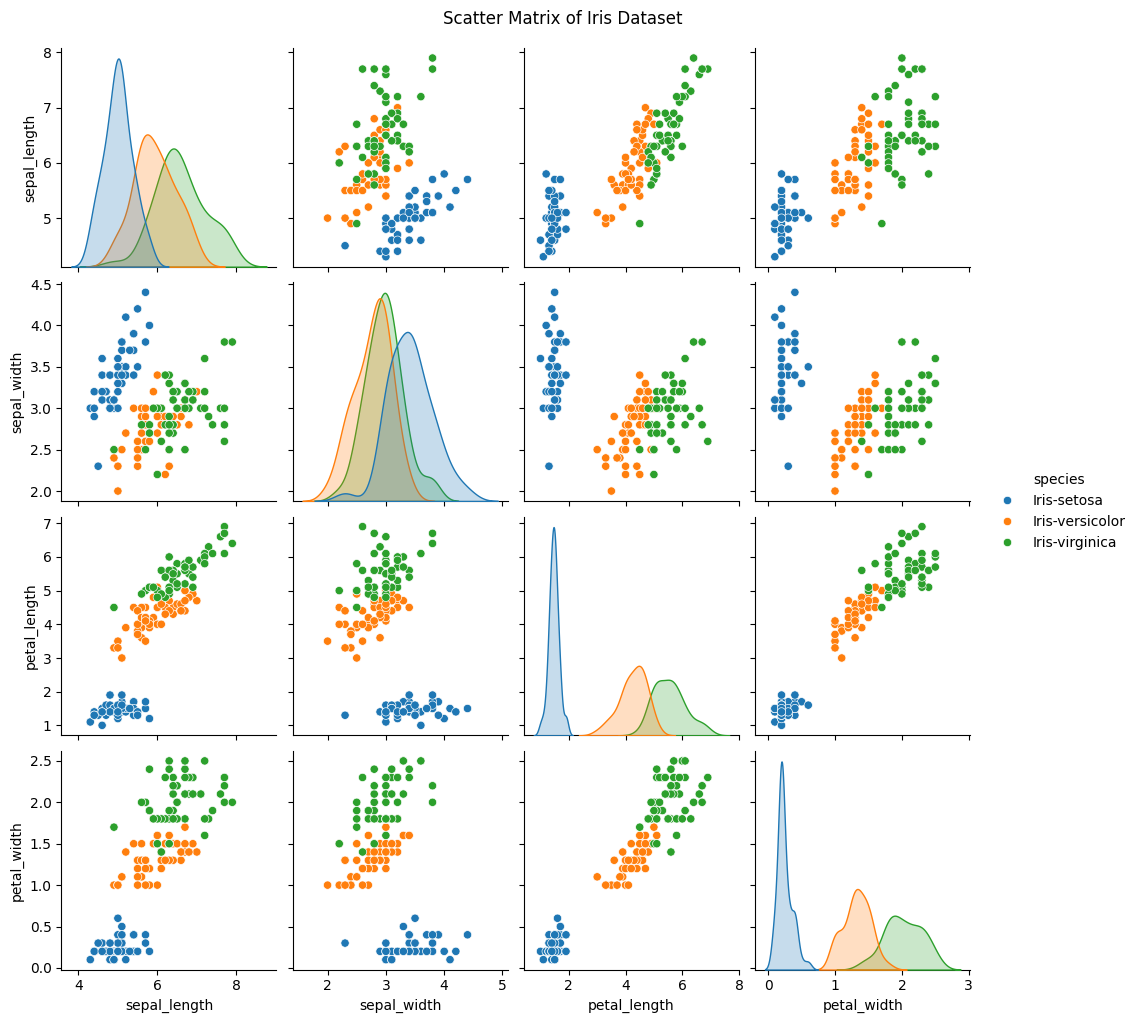

In [60]:
plotScatterMatrix(df, 12, 10)